Sound Event Detection using Approach 1

This colab demonstrates how to extract the AudioSet embeddings, using a VGGish deep neural network (DNN).

Based on the directions at: https://github.com/tensorflow/models/tree/master/research/audioset

In [1]:
!lscpu
!nvidia-smi

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.000
BogoMIPS:            4400.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [2]:
#Google drive access
import os
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)

#Directory
root_path = 'gdrive/My Drive/SoundEventDetection/modelTraining/'
os.chdir(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%%capture
#Install necessary software
!pip install six
!pip install h5py
!pip install pydub
!pip install numpy
!pip install scipy
!pip install keras
!pip install future
!pip install resampy
!pip install ipython
!pip install soundfile
!pip install pysoundfile
!pip install scikit-learn
!apt-get install libsndfile1

!pip install python==3.6
!pip install matplotlib
!pip install cudnn==7.1.2
!pip install cudatoolkit==9
!pip install tensorflow-gpu==1.12.0

#Install: cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1
#OR
#!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb

#VGGish model checkpoint, in TensorFlow checkpoint format.
import os 
os.chdir("trained_models")
!wget https://storage.googleapis.com/audioset/vggish_model.ckpt
os.chdir("..")

In [0]:
%%capture
#Important DO NOT DELETE
#import six
import sys
#import h5py
#import math
#import glob
import json
#import time
import numpy as np
import pandas as pd
import soundfile as sf
import tensorflow as tf
import matplotlib.pyplot as plt
#from pydub.playback import play
#from pydub import AudioSegment
#from scipy.io import wavfile
#from scipy.io.wavfile import write

sys.path.insert(1, os.path.join(sys.path[0], '../'))

#ML imports
#from keras.layers import Input, Dense, BatchNormalization, Dropout, Activation, Concatenate
from keras.layers import Lambda
from keras.optimizers import Adam
from keras.models import load_model
from keras.models import Model
import keras.backend as K

#External .py scripts
from lib import mel_features
from lib import vggish_input
from lib import vggish_params
from lib import vggish_postprocess
from lib import vggish_slim
from lib import utilities
from lib import data_generator
from lib.train_functions import evaluateCore, trainCore, average_pooling, max_pooling, attention_pooling, pooling_shape, train, writeToFile

In [0]:
%%capture
trainingType = ['decision_level_max_pooling', 
                'decision_level_average_pooling', 
                'decision_level_single_attention', 
                'decision_level_multi_attention', 
                'feature_level_attention']

balanced = ['no_balance', 'balance_in_batch']


def loadModel(num1,num2):
  args = {
          "data_dir" : "packed_features/",
          "workspace" : "workspace/",
          "mini_data" : False,
          "balance_type" : balanced[num2], #'no_balance', 'balance_in_batch'
          "model_type" : trainingType[num1], 
          "learning_rate" : 1e-3,
          "filename":utilities.get_filename("work/")
  }

  #Output directories
  sub_dir = os.path.join(args["filename"],
                        'balance_type={}'.format(args["balance_type"]),
                        'model_type={}'.format(args["model_type"]))
  
  modelFiles = [['200k_DLMP_B','200k_DLMP_U'],['200k_DLAP_B','200k_DLAP_U'],
                ['200k_DLSA_B','200k_DLSA_U'],['200k_DLMA_B','200k_DLMA_U'],
                ['200k_FLA_B','200k_FLA_U']]

  #CNN Architecture
  model = train(args, 1)
  optimizer = Adam(lr=args["learning_rate"])
  model.compile(loss='binary_crossentropy', optimizer=optimizer)

  #Model dir
  #models_dir ="workspace/models/work/balance_type=balance_in_batch/model_type=feature_level_attention"
  models_dir = "trained_models/"+modelFiles[num1][num2]+".h5"

  #latest_file ="workspace/models/work/balance_type=no_balance/model_type=decision_level_multi_attention/md_4000_iters.h5"
  print(models_dir)
  model.load_weights(models_dir)
  print(type(model))
  return model
  
model = loadModel(2,1)

In [6]:
'''
from keras.models import load_model
model = load_model( "trained_models/"+"200k_DLSA_U"+".h5")
'''

'\nfrom keras.models import load_model\nmodel = load_model( "trained_models/"+"200k_DLSA_U"+".h5")\n'

In [0]:
#start_time = time.time()
def getTime(num, start_time):
  print(str(num)+ ":" + str(time.time() - start_time))
  return time.time()

In [0]:
#Get labels
class_labels = pd.read_csv("lib/class.csv").drop(columns=['index','mid'])['display_name'].to_numpy()

def getLabeling(class_labels,num):
   return class_labels[num]

In [0]:
#Predict on input
def predictOnVggishInput(df, model):
  results = []
  attention_results = []
  #Handling edge case of 10 seconds
  length = df.shape[0]
  if(length==10):
    length = 11

  for endNumber in range(10,length):
    startNumber = endNumber - 10
    df_final = [df[startNumber:endNumber]]
    df_final = np.asarray(df_final)
    df_final = (np.float32(df_final) - 128.) / 128.
    output = model.predict(df_final)
    #attention_layer_output=model.get_layer(layer_name).output
    #intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)
    #attention_layer_prediction=intermediate_model.predict(df_final)
    #attention_results.append(attention_layer_prediction)
    results.append(output.astype(np.float32))
  return results

In [0]:
def plotResults(df):
  #Create plot
  plt.rcParams["figure.figsize"] = (20,10)
  groups = df.groupby('Class')
  # Plot
  fig, ax = plt.subplots()
  ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
  for name, group in groups:
      ax.plot(group.StartTime, group.Probability, marker='o', linestyle='-', ms=6, label=getLabeling(class_labels,name))

  f = "output/dogprobsld.csv"
  df = pd.read_csv(f)
  #plt.plot(df[df['Class']==0]['Second'],df[df['Class']==0]['Class']+1.1, marker='o', linestyle='', ms=6,color='C0', label="Speech SLD") 
  #plt.plot(df[df['Class']==74]['Second'],df[df['Class']==74]['Class']-72.8, marker='o', linestyle='', ms=6,color='C3', label="Dog SLD")

  ax.legend()
  #plt.xlim((0, 180))
  plt.show()

In [0]:
#VGGish transformation
def vggish_fullprocess(wav_file,data,sr,switch):
  # wav_file = "output/dog.wav" #tempSave
  checkpoint = "trained_models/vggish_model.ckpt"
  pca_params = "trained_models/vggish_pca_params.npz"

  if switch==1:
    examples_batch = vggish_input.wavfile_to_examples(wav_file)
  else:
    examples_batch = vggish_input.waveform_to_examples(data,sr)

  # Prepare a postprocessor to munge the model embeddings.
  pproc = vggish_postprocess.Postprocessor(pca_params)
  with tf.Graph().as_default(), tf.Session() as sess:
    # Define the model in inference mode, load the checkpoint, and
    # locate input and output tensors.
    vggish_slim.define_vggish_slim(training=False)
    vggish_slim.load_vggish_slim_checkpoint(sess, checkpoint)
    features_tensor = sess.graph.get_tensor_by_name(vggish_params.INPUT_TENSOR_NAME)
    embedding_tensor = sess.graph.get_tensor_by_name(vggish_params.OUTPUT_TENSOR_NAME)

    # Run inference and postprocessing.
    [embedding_batch] = sess.run([embedding_tensor],feed_dict={features_tensor: examples_batch})

  postprocessed_batch = pproc.postprocess(embedding_batch)

  return postprocessed_batch


In [0]:
# #Load vggish output
# filename = 'output/data.h5'

def predictOnAudioFile(wav_file):
  wav_data, sr = sf.read(wav_file, dtype='int16')
  assert wav_data.dtype == np.int16, 'Bad sample type: %r' % wav_data.dtype
  samples = wav_data / 32768.0  # Convert to [-1.0, +1.0]
  if len(samples.shape) > 1:
    data = np.mean(samples, axis=1)
  else:
    data = samples
  data = np.asarray(data)
  result_list = []

  step = int(data.shape[0]/sr)
  #step = 30
  for segment in np.arange(0,int(data.shape[0]/sr),step):
    if((data.shape[0]/sr)-segment<step):
      break

    if segment>0:
      segmentStart = segment - 9
    else:
      segmentStart = segment

    data_segment = data[sr*segmentStart:sr*(segment+step)]
    data_embedding = vggish_fullprocess(wav_file,data_segment,sr,2)
    result = predictOnVggishInput(data_embedding, model)
    result_list.append(result)
  return result_list

result_list = predictOnAudioFile('output/dog.wav')

In [13]:
len(result_list[0][0])

1

In [0]:
results = []
for i in range(0, len(result_list[0])):
  [t]  = result_list[0][i]
  for j in range(0,len(t)):
    if t[j] < 0.25:
      t[j] = 0
  t = t.tolist()
  results.append(t)

results = np.asarray(results)

results = np.transpose(results)

In [15]:
results

array([[0.98942566, 0.98856789, 0.93964893, ..., 0.93250531, 0.92475653,
        0.90739918],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [16]:
len(result_list)

1

In [17]:
masterList = []
counter = 1
for i in result_list[0]:
  a = np.argpartition(i[0], -10)[-10:]
  secondsMap={}
  valuesMap={}
  for aa in a:
    valuesMap[getLabeling(class_labels,aa)] = 1.*i[0][aa]
  secondsMap['second'] = counter
  secondsMap['values'] = valuesMap
  masterList.append(secondsMap)
  counter = counter + 1

json.dumps(masterList)

'[{"second": 1, "values": {"Wood block": 0.0, "Cymbal": 0.0, "Rimshot": 0.0, "Mallet percussion": 0.0, "Tambourine": 0.0, "Rattle (instrument)": 0.0, "Maraca": 0.0, "Gong": 0.0, "Tubular bells": 0.0, "Speech": 0.9894256591796875}}, {"second": 2, "values": {"Wood block": 0.0, "Cymbal": 0.0, "Rimshot": 0.0, "Mallet percussion": 0.0, "Tambourine": 0.0, "Rattle (instrument)": 0.0, "Maraca": 0.0, "Gong": 0.0, "Tubular bells": 0.0, "Speech": 0.9885678887367249}}, {"second": 3, "values": {"Wood block": 0.0, "Cymbal": 0.0, "Rimshot": 0.0, "Mallet percussion": 0.0, "Tambourine": 0.0, "Rattle (instrument)": 0.0, "Maraca": 0.0, "Gong": 0.0, "Tubular bells": 0.0, "Speech": 0.9396489262580872}}, {"second": 4, "values": {"Wood block": 0.0, "Cymbal": 0.0, "Rimshot": 0.0, "Mallet percussion": 0.0, "Tambourine": 0.0, "Rattle (instrument)": 0.0, "Maraca": 0.0, "Gong": 0.0, "Tubular bells": 0.0, "Speech": 0.9396762847900391}}, {"second": 5, "values": {"Wood block": 0.0, "Cymbal": 0.0, "Rimshot": 0.0, "Ma

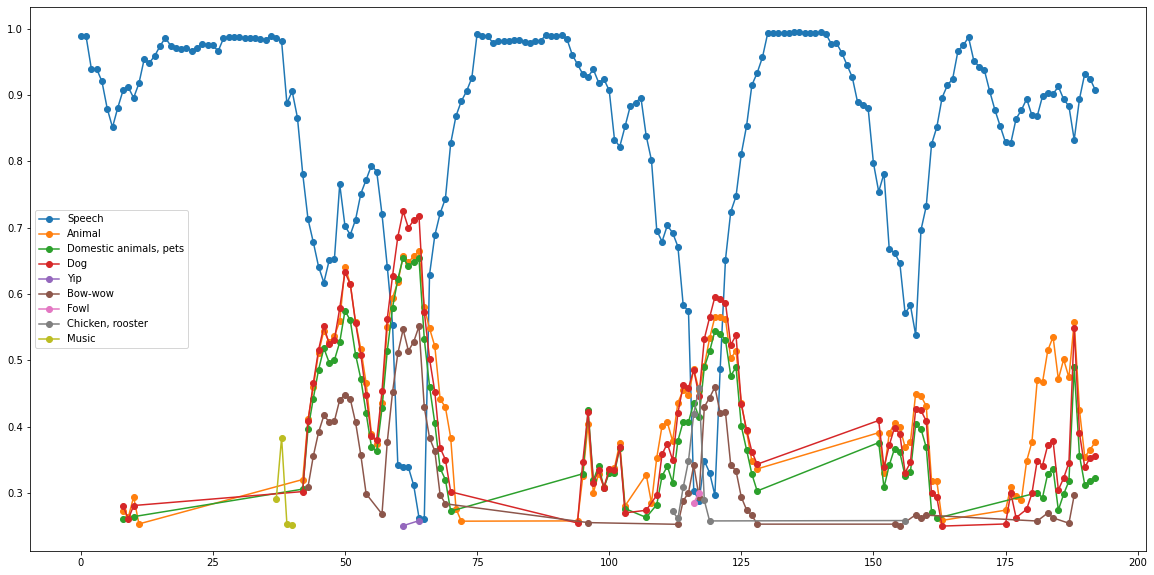

,StartTime,Class,Probability
0,0.0,0,0.989426
1,1.0,0,0.988568
2,2.0,0,0.939649
3,3.0,0,0.939676
4,4.0,0,0.920625
5,5.0,0,0.879799
6,6.0,0,0.851511
7,7.0,0,0.881224
8,8.0,0,0.907235
9,8.0,72,0.273296


In [23]:
# Manipulate results
result_table = pd.DataFrame(columns=['StartTime','Class','Probability'])
i = 0
threshold = 0.2
for result_segment in result_list:
  for result in result_segment:
    result = result[0]
    classes = np.arange(len(result))[result>threshold]
    probs = result[result>threshold]
    for j in np.arange(len(probs)):
      result_table = result_table.append({'StartTime' : 0+i,'Class' : classes[j] , 'Probability' : probs[j]}, ignore_index=True)
    i=i+1

  result_table["Class"] = result_table["Class"].astype(int)

# Change column type
# result_table['Class'] = pd.Categorical(result_table.Class)
plotResults(result_table)
result_table.head(20)

In [0]:
rdf = result_table
rdf['EndTime'] = rdf['StartTime'] + 10

In [0]:
def calc_weighted_prob(data):
  data['middle_second'] = data[['StartTime','EndTime']].mean(axis=1)
  data['weight'] = (5- abs(data['second'] - data['middle_second']))+1
  weight_sum = data['weight'].sum()
  data['weight'] = data['weight']/weight_sum
  data['weighted_prob'] = data['Probability'] * data['weight']
  d = {'second': data['second'].iloc[0],'Class': data['Class'].iloc[0] , 'smoothed_prob': [data['weighted_prob'].sum()]}
  smoothed_prob = pd.DataFrame(data=d)
  return smoothed_prob

In [0]:
def plotSmoothedResults(df):
  #Create plot
  plt.rcParams["figure.figsize"] = (20,10)
  groups = df.groupby('Class')
  # Plot
  fig, ax = plt.subplots()
  ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
  for name, group in groups:
      ax.plot(group.second, group.smoothed_prob, marker='o', linestyle='-', ms=6, label=getLabeling(class_labels,name))

  f = "output/dogprobsld.csv"
  df = pd.read_csv(f)
  #plt.plot(df[df['Class']==0]['Second'],df[df['Class']==0]['Class']+1.1, marker='o', linestyle='', ms=6,color='C0', label="Speech SLD") 
  #plt.plot(df[df['Class']==74]['Second'],df[df['Class']==74]['Class']-72.8, marker='o', linestyle='', ms=6,color='C3', label="Dog SLD")

  ax.legend()
  #plt.xlim((0, 180))
  plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

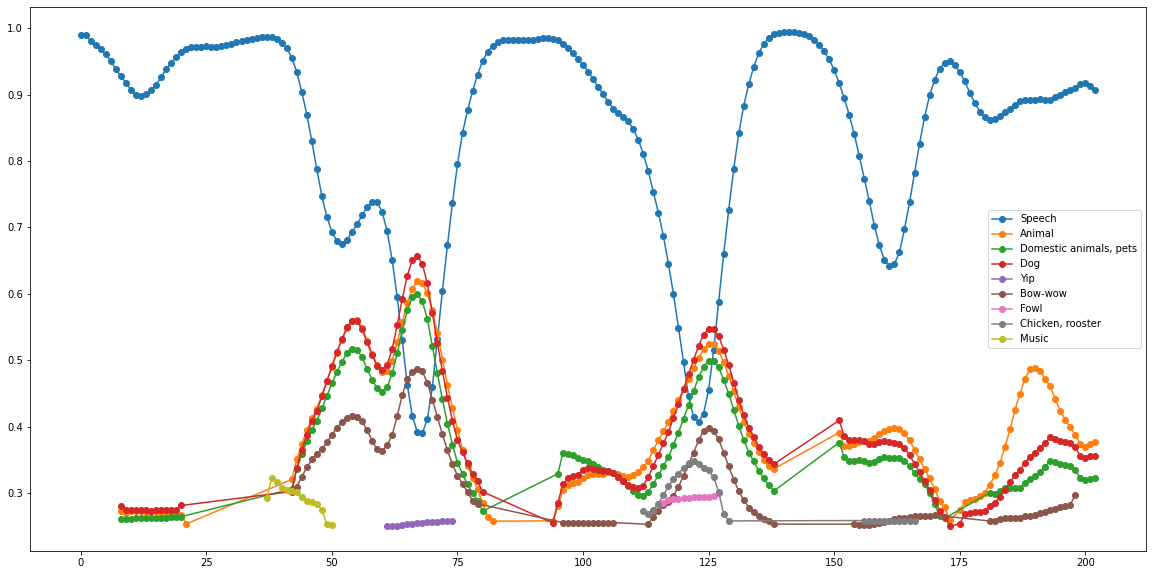

In [22]:
first_second = np.min(rdf['StartTime'])
last_second = np.max(rdf['EndTime'])

smoothed_results = pd.DataFrame(columns=['second','Class','smoothed_prob'])

for second in np.arange(first_second,last_second+1):
  data_second = rdf[(rdf['StartTime'] <=second) & (rdf['EndTime'] >= second)]
  data_second['second'] = second
  for Class in np.unique(np.asarray(data_second['Class'])):
    df = calc_weighted_prob(data_second[data_second['Class']==Class])
    smoothed_results = smoothed_results.append(df)

plotSmoothedResults(smoothed_results)